In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

df = pd.read_csv('../data/processed/Dronninglund_treated_data_and_flow_rates.csv', index_col=0, parse_dates=True)
water_sensors = ['T_{:04.1f}'.format(height) for height in np.linspace(16, 0.5, 32)]
df_water_sensors = df[water_sensors[::-1]]
df_water_sensors.columns = [float(c[2:]) for c in water_sensors[::-1]]
water_sensors = df_water_sensors['2017':'2020']
water_sensors_ = water_sensors.resample('h').mean()
water_sensors = water_sensors_.iloc[19500:26000]
water_sensors_train = water_sensors_.iloc[3000:7500]
p1d = pd.read_csv('../predictions/p1d.csv', index_col=0)
p2d = pd.read_csv('../predictions/p2d.csv', index_col=0)
p1w = pd.read_csv('../predictions/p1w.csv', index_col=0)
p2w = pd.read_csv('../predictions/p2w.csv', index_col=0)
p1m = pd.read_csv('../predictions/p1m.csv', index_col=0)
sim = pd.read_csv('../predictions/sim.csv', index_col=0)

train_p1d = pd.read_csv('../predictions/train_p1d.csv', index_col=0)
train_p2d = pd.read_csv('../predictions/train_p2d.csv', index_col=0)
train_p1w = pd.read_csv('../predictions/train_p1w.csv', index_col=0)
train_p2w = pd.read_csv('../predictions/train_p2w.csv', index_col=0)
train_p1m = pd.read_csv('../predictions/train_p1m.csv', index_col=0)
train_sim = pd.read_csv('../predictions/train_sim.csv', index_col=0)


In [102]:
water_sensors_train

,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,...,11.5,12.0,12.5,13.0,13.5,14.0,14.5,15.0,15.5,16.0
2017-05-06 00:00:00+01:00,16.600000,16.500000,16.500000,16.500000,16.600000,16.600000,16.500000,16.500000,16.500000,16.700000,...,30.400000,30.616667,30.850000,30.966667,31.500000,39.466667,55.233333,69.750000,78.600000,79.700000
2017-05-06 01:00:00+01:00,16.600000,16.500000,16.500000,16.500000,16.600000,16.600000,16.500000,16.500000,16.500000,16.700000,...,30.433333,30.716667,30.900000,31.000000,31.483333,39.200000,54.950000,69.550000,78.483333,79.700000
2017-05-06 02:00:00+01:00,16.600000,16.533333,16.566667,16.500000,16.516667,16.600000,16.500000,16.500000,16.600000,16.700000,...,30.500000,30.800000,30.916667,31.000000,31.500000,38.883333,54.700000,69.333333,78.400000,79.650000
2017-05-06 03:00:00+01:00,16.600000,16.550000,16.600000,16.500000,16.583333,16.600000,16.500000,16.500000,16.600000,16.633333,...,30.550000,30.833333,30.950000,31.016667,31.450000,38.600000,54.433333,69.133333,78.266667,79.600000
2017-05-06 04:00:00+01:00,16.600000,16.500000,16.533333,16.500000,16.600000,16.600000,16.500000,16.500000,16.600000,16.616667,...,30.650000,30.850000,30.966667,31.000000,31.466667,38.333333,54.100000,68.916667,78.166667,79.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-09 07:00:00+01:00,18.700000,18.700000,18.800000,18.800000,19.066667,19.750000,20.516667,22.233333,25.866667,32.833333,...,42.000000,42.100000,42.200000,42.200000,42.400000,42.600000,42.900000,44.000000,46.533333,49.483333
2017-11-09 08:00:00+01:00,18.783333,18.750000,18.850000,18.816667,19.033333,19.700000,20.433333,22.050000,25.516667,32.550000,...,42.000000,42.100000,42.200000,42.200000,42.400000,42.600000,42.900000,43.950000,46.483333,49.466667
2017-11-09 09:00:00+01:00,18.800000,18.816667,18.916667,18.883333,19.100000,19.633333,20.350000,21.950000,25.150000,32.200000,...,42.000000,42.100000,42.200000,42.200000,42.400000,42.600000,42.900000,43.933333,46.400000,49.400000
2017-11-09 10:00:00+01:00,18.716667,18.816667,18.966667,18.900000,19.050000,19.533333,20.300000,21.800000,24.883333,31.866667,...,42.000000,42.100000,42.200000,42.200000,42.400000,42.600000,42.900000,43.900000,46.400000,49.300000


array([ 0.        ,  0.51612903,  1.03225806,  1.5483871 ,  2.06451613,
        2.58064516,  3.09677419,  3.61290323,  4.12903226,  4.64516129,
        5.16129032,  5.67741935,  6.19354839,  6.70967742,  7.22580645,
        7.74193548,  8.25806452,  8.77419355,  9.29032258,  9.80645161,
       10.32258065, 10.83870968, 11.35483871, 11.87096774, 12.38709677,
       12.90322581, 13.41935484, 13.93548387, 14.4516129 , 14.96774194,
       15.48387097, 16.        ])

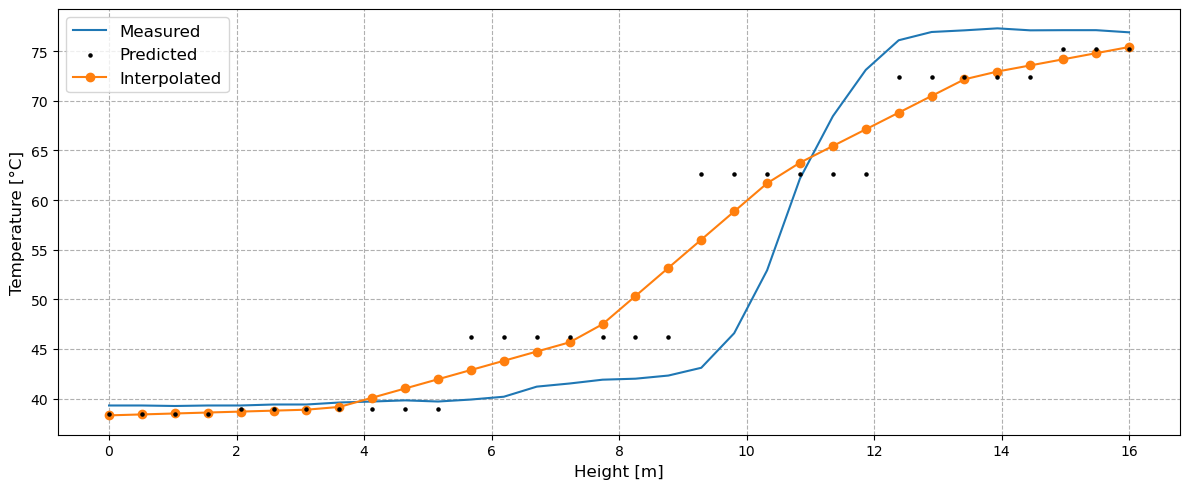

In [238]:
fig, (ax) = plt.subplots(1, 1, figsize=(12, 5), sharex=True)
x1 = np.linspace(0, 16, 32)
x2 = np.linspace(0, 16, 6)
x3 = np.linspace(0, 16, 100)
x2 = np.array([0.5,3.5,7.5,10.5,13.5,15.8])
idx = 5000
f = interp1d(x2, p2w.iloc[idx], kind='linear', fill_value='extrapolate')
f2 = interp1d(x2, p2w.iloc[idx], kind='quadratic', fill_value='extrapolate')
f3 = interp1d(x2, p2w.iloc[idx], kind='nearest', fill_value='extrapolate')

y = f(x1)
y2 = f2(x1)
y3 = f3(x1)
ax.plot(x1,water_sensors.iloc[idx], label='Measured')
# ax.plot(x1,y2, marker = 'o', label='Predicted quadratic')
ax.scatter(x1,y3, label='Predicted',s = 5, color = 'k', zorder = 3)
# ax.scatter(x2, p1d.iloc[idx], marker = '.', color = 'C1')
ax.plot(x1,y, marker = 'o', label='Interpolated')

ax.grid(linestyle = '--')


# idx = 4200
# f = interp1d(x2, p2d.iloc[idx], kind='linear', fill_value='extrapolate')
# f2 = interp1d(x2, p2d.iloc[idx], kind='quadratic', fill_value='extrapolate')
# f3 = interp1d(x2, p2d.iloc[idx], kind='nearest-up', fill_value='extrapolate')

# y = f(x1)
# y2 = f2(x1)
# y3 = f3(x1)
# ax1.plot(x1,water_sensors.iloc[idx], label='Measured')
# ax1.plot(x1,y2, marker = 'o', label='Predicted quadratic')
# ax1.scatter(x2, p2d.iloc[idx], marker = '.', color = 'C1')
# ax1.scatter(x1,y3, label='Predicted',s = 5, color = 'k', zorder = 3)

# ax1.plot(x1,y, marker = 'o', label='Interpolated', alpha = 1)


# ax1.grid(linestyle = '--')
# ax.set_xticks(np.arange(0, 16, 2));
# ax.set_xticklabels(np.linspace(0,16,6).round(2));

ax.set_xlabel('Height [m]', fontsize = 12)
ax.set_ylabel('Temperature [°C]', fontsize = 12)
# ax1.legend()

ax.legend(loc='upper left', fontsize = 12)
fig.tight_layout()
x2
# ax[1].plot(x1, y - water_sensors.iloc[idx])
x1


In [104]:
x2

array([ 1. ,  3.5,  7.5, 10.5, 13.5, 16. ])

# Evaluation

In [105]:
# Volumes
a = 90.4 # side length of top surface
layer_height = 0.5 # water layer height

volume_per_layer = []
top_area_per_layer = []
for _ in range(1, 33):
    b = a - 2 # the slope is 1:2 thus giving 1 m length at each side
    layer_volume = layer_height / 3 *(a**2 + a*b + b**2)
    volume_per_layer.append(layer_volume)
    top_area_per_layer.append(a**2)
    a = b

top_area_per_layer.append(b**2)

# volume_per_layer = pd.Series(volume_per_layer)
volume_per_layer = volume_per_layer[::-1]
# top_area_per_layer = pd.Series(top_area_per_layer)
top_area_per_layer = top_area_per_layer[::-1]

x = np.linspace(0, 16, 33)
d = interp1d(x, np.cumsum([0] + volume_per_layer), kind='quadratic')
x = np.linspace(0, 16, 33)
a = interp1d(x, top_area_per_layer, kind='quadratic')

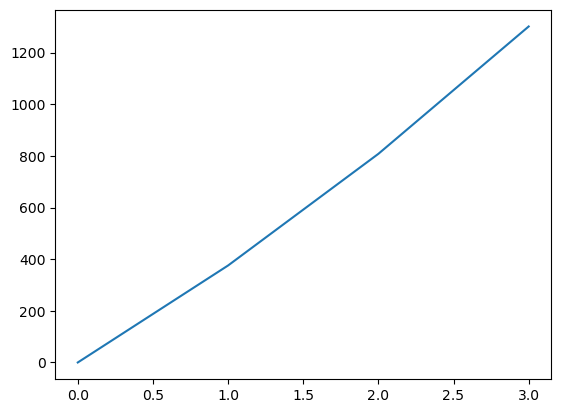

In [106]:
plt.plot(np.cumsum([0]+volume_per_layer)[:4]) 
# plt.plot(top_area_per_layer)  ¨


In [107]:
def getVolandCentroid(z, dz):
    a_bot = a(z)
    a_top = a(z+dz)
    volume = d(z+dz) - d(z)
    a_, b_ = np.sqrt(a_top), np.sqrt(a_bot)
    centroid = dz - dz * (a_top+2*a_*b_+3*a_bot) / (2*(2*a_top+2*a_*b_+2*a_bot))

    return volume, centroid + z


z = np.arange(0, 16, 0.5 )
dz = 0.5


In [108]:
water_sensors.min()

0.5     11.466667
1.0     11.500000
1.5     11.733333
2.0     11.800000
2.5     11.916667
3.0     12.250000
3.5     12.300000
4.0     12.366667
4.5     12.500000
5.0     12.700000
5.5     12.683333
6.0     12.733333
6.5     12.900000
7.0     13.100000
7.5     13.000000
8.0     13.200000
8.5     13.300000
9.0     13.300000
9.5     13.300000
10.0    13.300000
10.5    13.300000
11.0    13.300000
11.5    13.300000
12.0    13.300000
12.5    13.400000
13.0    13.400000
13.5    14.066667
14.0    20.250000
14.5    32.766667
15.0    38.900000
15.5    38.900000
16.0    38.733333
dtype: float64

In [109]:
# Compute that god damm MIX number!
TMIN, TMAX = 10, 90
from scipy.optimize import minimize
from tqdm import tqdm

def density_water(T):
    '''Density (rho) of water in kg/m^3 based on fluid temperature (T) nearest the flow meter in degrees Celsius'''
    rho = (999.85+5.332*(10**-2)*T-7.564*(10**-3)*(T**2)+4.323*(10**-5)*(T**3)-1.673*(10**-7)*(T**4)+2.447*(10**-10)*(T**5))
    return(rho)

def specific_heat_water(T):
    '''Specific heat (cp) of water in J/(kg K) based on mean fluid temperature (T) in degrees Celsius'''
    cp = (4.2184-2.8218*(10**-3)*T+7.3478*(10**-5)*(T**2)-9.4712*(10**-7)*(T**3)+7.2869*(10**-9)*(T**4)-2.8098*(10**-11)*(T**5)
          +4.4008*(10**-14)*(T**6))*1000
    return(cp)

def mass(T, V):
    ''' Returns the mass profile of the storage given temperatures T and volumes V'''
    return density_water(T)*V

def energy(T, V):
    ''' Returns the energy profile of the storage given temperatures T and volumes V'''
    return mass(T, V)*specific_heat_water(T)*(T-TMIN)

def energy_content(y, v):
    ''' Returns the energy content of the storage given temperatures y and volumes v'''
    if (type(y) == pd.DataFrame) or (type(y) == pd.Series):

        y = y.values
        if y.ndim == 1:
            y = y.reshape(1, -1)
        E = energy(y, v)
        return E.sum(axis =1)
    else:
        E = energy(y, v)
        return E.sum()

    
def energy_moment(y, v, c):
    ''' Returns the energy moment of the storage given temperatures y, volumes v and centroids c'''
    if (type(y) == pd.DataFrame) or (type(y) == pd.Series):
        y = y.values
        if y.ndim == 1:
            y = y.reshape(1, -1)
        
        E = energy(y, v)
        return (E * c).sum(axis =1)
    else:
        E = energy(y, v)
        return (E * c)

def energy_moment_mixed(y, v, c):
    M = mass(y, v)
    T_avg2 = (M * y).sum(axis=1) / M.sum(axis=1)
    T_avg2 = pd.DataFrame(np.ones_like(y) * T_avg2.values.reshape(-1,1))
    Me_mix = energy_moment(T_avg2, v, c)
    E_mix = energy_content(T_avg2, v)
    return Me_mix, E_mix

def stratification_coefficient(y, v, c):
    m = mass(y, v)
    M = m.sum(axis=1)
    T_avg = y.mean(axis=1)
    strat = (m * (y-y.mean(axis = 1).values.reshape(-1,1))**2).sum(axis=1) / M
    return strat.values.reshape(-1)

def energy_moment_stratified(y, v, c):

    def objective(z, E_exp):
        dz = 16 - z
        v, c = getVolandCentroid(z, dz)
        E_str = energy_content(TMAX, v)

        return pow((E_exp) - (E_str),2)
    
    E_exp = energy_content(y, v)
    Z = []
    V = []
    Me_str = []
    E_str = []
    x0 = 20
    for idx in tqdm(range(len(E_exp))):
        res = minimize(objective, x0, args=(E_exp[idx]), bounds=[(1, 15)])
        x0 = res.x
        v, c = getVolandCentroid(x0, 16-x0)
        e = energy_moment(TMAX, v, c)
        Me_str.append(e)
        E_str.append(energy_content(TMAX, v))
        Z.append(x0)
        V.append(v)
    Me_str = np.array(Me_str).reshape(-1)
    Z = np.array(Z).reshape(-1)
    V = np.array(V).reshape(-1)
    return Me_str, E_str, Z, V

y = water_sensors
z = np.arange(0, 16, 0.5)
dz = 0.5

v, c = getVolandCentroid(z, dz)
N = len(z)
E_true = energy_content(y, v)

Me_true = energy_moment(y, v, c)
Me_Mix_true, E_mix = energy_moment_mixed(y, v, c)
Me_str_true, E_str_true, Z, V = energy_moment_stratified(y, v, c)

Str_true = stratification_coefficient(y, v, c)

100%|██████████| 6500/6500 [00:17<00:00, 363.58it/s]


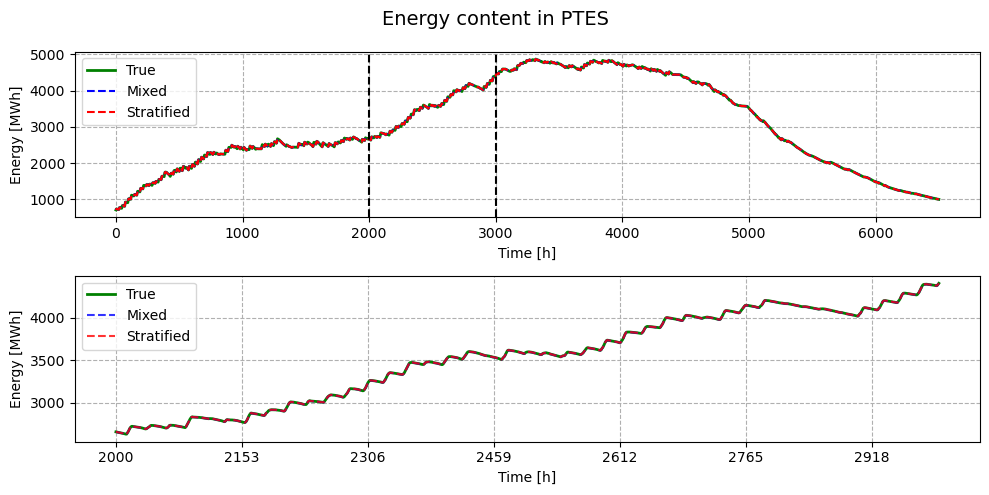

In [110]:
fig, (ax) = plt.subplots(2, 1, figsize=(10, 5))
# ax.plot(E_true)
E_str_true = np.array(E_str_true)
ax[0].plot(E_true/3600000000, label='True', color='green',linewidth = 2)
ax[0].plot(E_mix/3600000000, label='Mixed', color='blue', linestyle='--')
ax[0].plot(E_str_true/3600000000, label='Stratified', color='red', linestyle='--')
ax[0].set_ylabel('Energy [MWh]')
ax[0].set_xlabel('Time [h]')

# show lines where zoomed in
ax[0].axvline(2000, color='black', linestyle='--')
ax[0].axvline(3000, color='black', linestyle='--')
ax[0].legend(loc = 'upper left')
ax[0].grid(linestyle = '--')

ax[1].plot(E_true[2000:3000]/3600000000, label='True', color='green',linewidth = 2)
ax[1].plot(E_mix[2000:3000]/3600000000, label='Mixed', color='blue', linestyle='--', alpha=0.8)
ax[1].plot(E_str_true[2000:3000]/3600000000, label='Stratified', color='red', linestyle='--', alpha=0.8)

ax[1].set_xticks(np.arange(0, 1001, 153))
ax[1].set_xticklabels(np.arange(2000, 3001, 153))
ax[1].set_ylabel('Energy [MWh]')
ax[1].set_xlabel('Time [h]')
ax[1].legend()
ax[1].grid(linestyle = '--')

# overall title
fig.suptitle('Energy content in PTES', fontsize=14)
fig.tight_layout()

# ax1.plot(V)
# ax.plot(np.log(E_true) - np.log(E_str_true))
# ax.plot(np.log(E_mix))
# ax.plot(np.log(E_str_true))

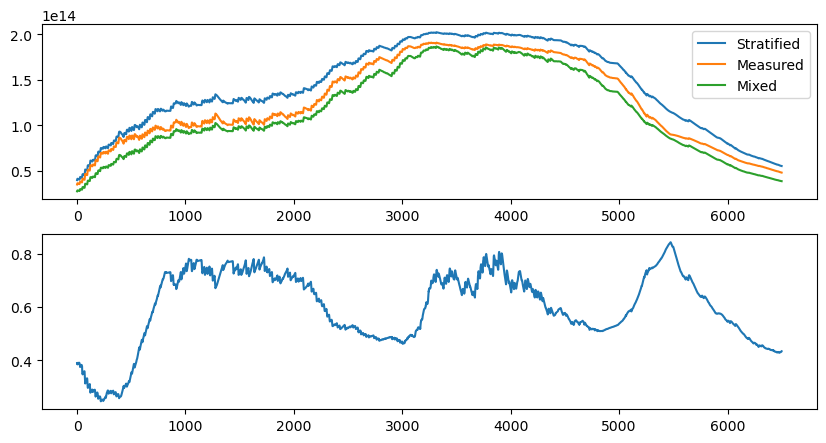

In [111]:
fig, ax = plt.subplots(2,1, figsize=(10, 5))
ax[0].plot(Me_str_true, label='Stratified')
ax[0].plot(Me_true, label='Measured')
ax[0].plot(Me_Mix_true, label='Mixed')
ax[0].legend()

MIX_true = (Me_str_true - Me_true)/(Me_str_true - Me_Mix_true)
ax[1].plot(MIX_true)


In [175]:
y = p1w
x1 = np.linspace(0, 16, 6)
z = np.arange(0, 16, 0.5)
dz = 0.5

x1= np.array([1,3.5,7.5,10.5,13.5,16])
# f = interp1d(x2, p1d.iloc[idx], kind='linear', fill_value='extrapolate')

def getMetrics(pred):
    newdata = pred.apply(lambda x: interp1d(x1, x, kind='slinear', fill_value='extrapolate')(z), axis=1)
    newdata = newdata.values
    newdata = np.vstack(newdata)
    newdata = pd.DataFrame(newdata, index=pred.index, columns=z)
    y = newdata

    v, c = getVolandCentroid(z, dz)
    N = len(z)
    E = energy_content(y, v)


    E = energy_content(y, v)
    Me = energy_moment(y, v, c)
    Me_Mix,_  = energy_moment_mixed(y, v, c)
    Me_str, _, Z, V = energy_moment_stratified(y, v, c)
    S = stratification_coefficient(y, v, c)
    
    return Me, Me_Mix, Me_str, E, V, S


preds = [p1d, p2d, p1w, p2w, p1m, sim]
Me, Me_Mix, Me_str, E, V, S = [], [], [], [], [], []
for pred in preds:
    m, m_mix, m_str, e, v, s = getMetrics(pred)
    Me.append(m)
    Me_Mix.append(m_mix)
    Me_str.append(m_str)
    E.append(e)
    V.append(v)
    S.append(s)


100%|██████████| 6501/6501 [00:17<00:00, 377.26it/s]


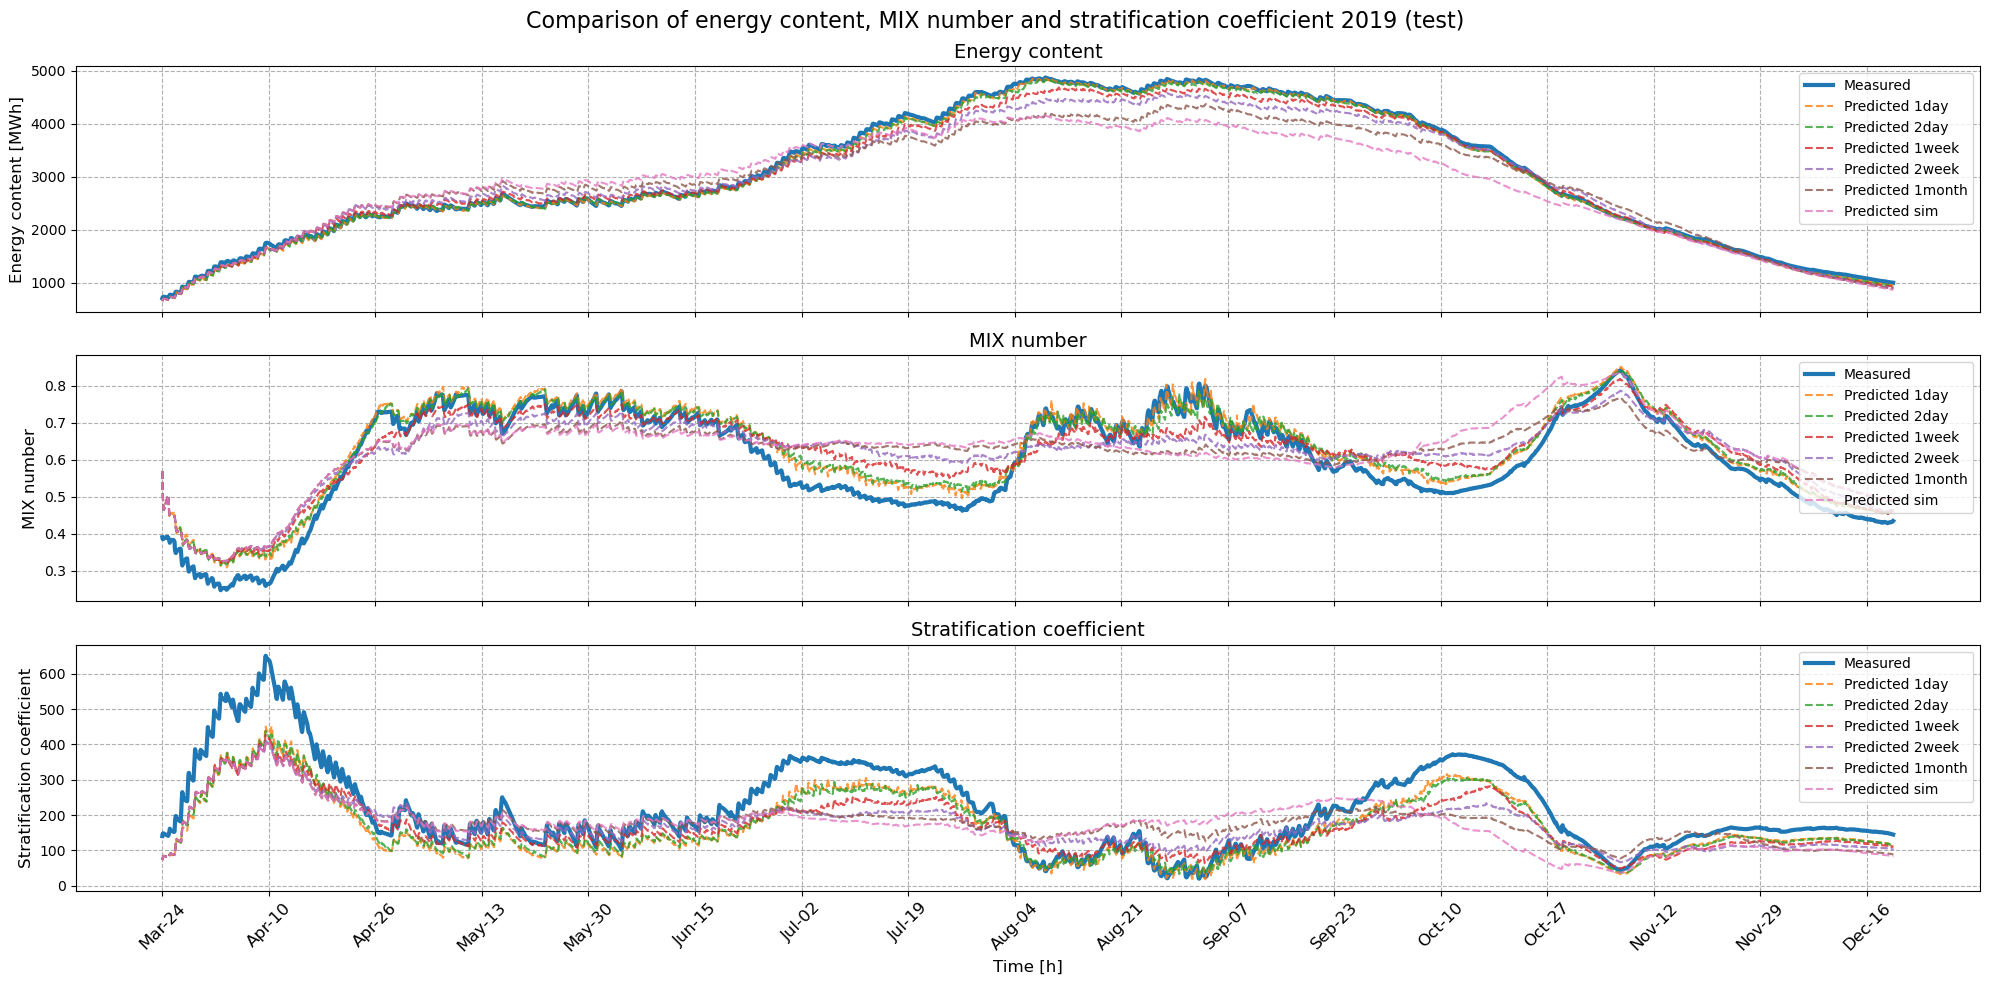

In [176]:
fig, ax = plt.subplots(3,1, figsize=(20, 10), sharex=True)
labels = ['1day', '2day', '1week', '2week', '1month', 'sim']

ax[0].plot((E_true)/3600000000, label='Measured', linewidth=3)
ax[1].plot(MIX_true, label='Measured', linewidth=3)
ax[2].plot(Str_true, label='Measured', linewidth=3)

for i in range(len(Me)):
    ax[0].plot((E[i]/3600000000), label=f'Predicted {labels[i]}', linestyle='--', alpha = 0.8)
    MIX = (Me_str[i] - Me[i])/(Me_str[i] - Me_Mix[i])
    ax[1].plot(MIX, label=f'Predicted {labels[i]}', linestyle='--', alpha = 0.8)

    ax[2].plot(S[i], label=f'Predicted {labels[i]}', linestyle='--', alpha = 0.8)

ax[0].legend(loc = 'upper right', fontsize = 10)
ax[0].set_title('Energy content', fontsize = 14)
ax[0].set_ylabel('Energy content [MWh]', fontsize = 12)
ax[0].grid(linestyle = '--')

# ax[1].set_xlabel('Time [h]')
ax[1].legend(loc = 'upper right', fontsize = 10)
ax[1].set_title('MIX number', fontsize = 14)
ax[1].grid(linestyle = '--')
ax[1].set_ylabel('MIX number', fontsize = 12)

ax[2].set_xlabel('Time [h]', fontsize = 12)
ax[2].legend(loc = 'upper right', fontsize = 10)
ax[2].set_title('Stratification coefficient', fontsize = 14)
ax[2].grid(linestyle = '--')
ax[2].set_ylabel('Stratification coefficient', fontsize = 12)

index = water_sensors.index
ticks = np.arange(0, len(index), 400)
tick_labels = [index[t].strftime('%b-%d') for t in ticks]
ax[2].set_xticks(ticks)
ax[2].set_xticklabels(tick_labels, rotation=45, fontsize = 12)
# ax[2].se

# Set overall title
fig.suptitle('Comparison of energy content, MIX number and stratification coefficient 2019 (test)', fontsize = 16)
fig.tight_layout()

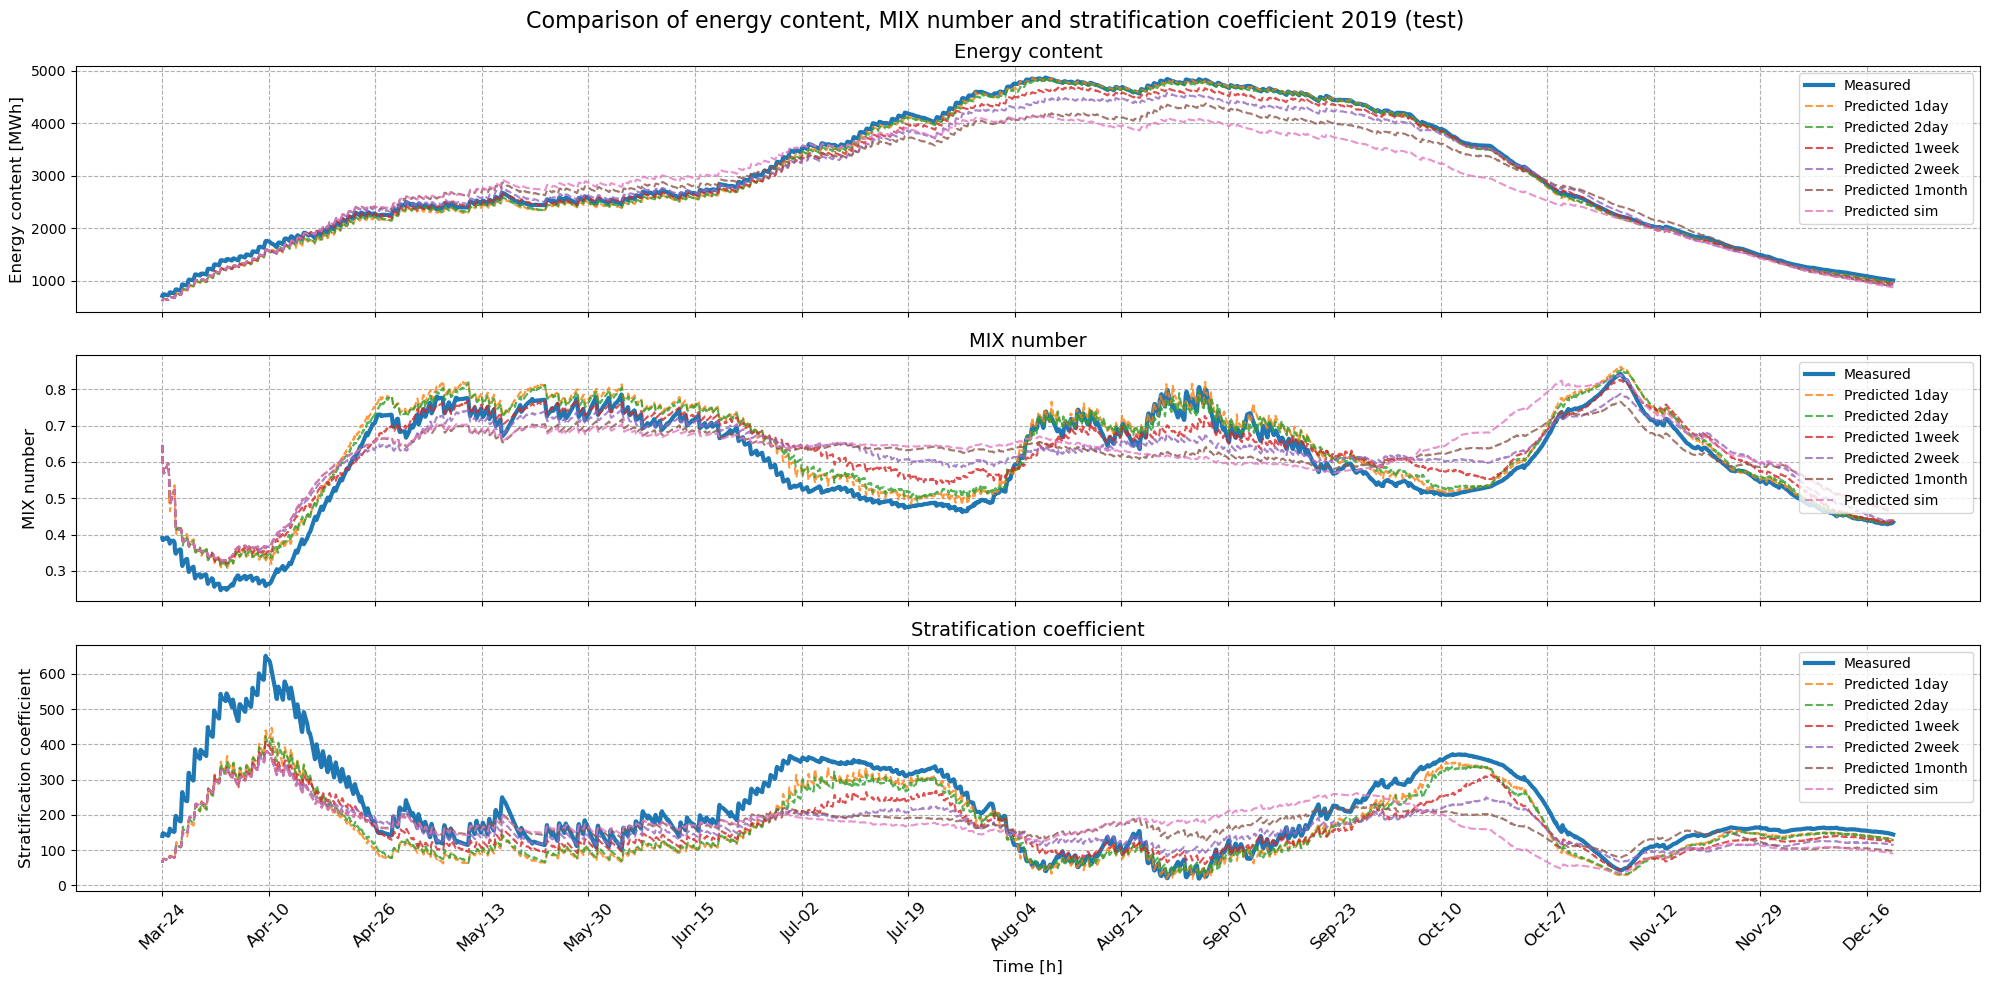

In [134]:
fig, ax = plt.subplots(3,1, figsize=(20, 10), sharex=True)
labels = ['1day', '2day', '1week', '2week', '1month', 'sim']

ax[0].plot((E_true)/3600000000, label='Measured', linewidth=3)
ax[1].plot(MIX_true, label='Measured', linewidth=3)
ax[2].plot(Str_true, label='Measured', linewidth=3)

for i in range(len(Me)):
    ax[0].plot((E[i]/3600000000), label=f'Predicted {labels[i]}', linestyle='--', alpha = 0.8)
    MIX = (Me_str[i] - Me[i])/(Me_str[i] - Me_Mix[i])
    ax[1].plot(MIX, label=f'Predicted {labels[i]}', linestyle='--', alpha = 0.8)

    ax[2].plot(S[i], label=f'Predicted {labels[i]}', linestyle='--', alpha = 0.8)

ax[0].legend(loc = 'upper right', fontsize = 10)
ax[0].set_title('Energy content', fontsize = 14)
ax[0].set_ylabel('Energy content [MWh]', fontsize = 12)
ax[0].grid(linestyle = '--')

# ax[1].set_xlabel('Time [h]')
ax[1].legend(loc = 'upper right', fontsize = 10)
ax[1].set_title('MIX number', fontsize = 14)
ax[1].grid(linestyle = '--')
ax[1].set_ylabel('MIX number', fontsize = 12)

ax[2].set_xlabel('Time [h]', fontsize = 12)
ax[2].legend(loc = 'upper right', fontsize = 10)
ax[2].set_title('Stratification coefficient', fontsize = 14)
ax[2].grid(linestyle = '--')
ax[2].set_ylabel('Stratification coefficient', fontsize = 12)

index = water_sensors.index
ticks = np.arange(0, len(index), 400)
tick_labels = [index[t].strftime('%b-%d') for t in ticks]
ax[2].set_xticks(ticks)
ax[2].set_xticklabels(tick_labels, rotation=45, fontsize = 12)
# ax[2].se

# Set overall title
fig.suptitle('Comparison of energy content, MIX number and stratification coefficient 2019 (test)', fontsize = 16)
fig.tight_layout()

<BarContainer object of 6 artists>

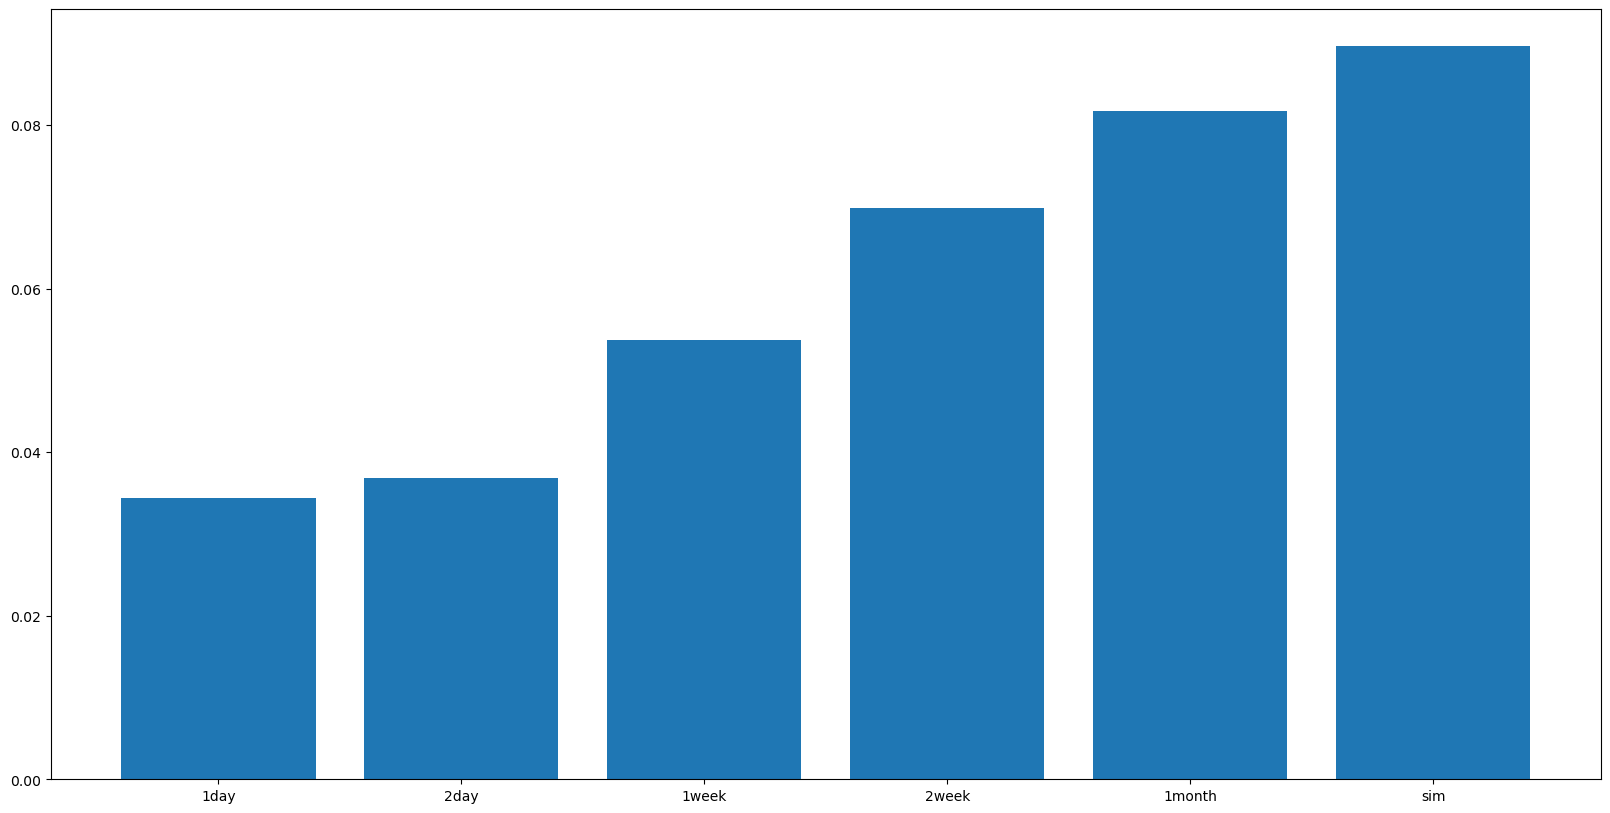

In [258]:
fig, ax = plt.subplots(1,1, figsize=(20, 10), sharex=True)
RMSE = []
for i in range(len(Me)):
    MIX = (Me_str[i] - Me[i])/(Me_str[i] - Me_Mix[i])
    MIX = MIX[1:]
    
    RMSE.append(np.sqrt(np.mean((MIX - MIX_true)**2)))

ax.bar(labels, RMSE)
# index = water_sensors.index
# ticks = np.arange(0, len(index), 400)
# tick_labels = [index[t].strftime('%b-%d') for t in ticks]
# ax.set_xticks(ticks)
# ax.set_xticklabels(tick_labels, rotation=45, fontsize = 12)
# ax.grid(linestyle = '--')

In [ ]:
y = p1w
x1 = np.linspace(0, 16, 6)
z = np.arange(0, 16, 0.5)
dz = 0.5

def getMetrics(pred):
    newdata = pred.apply(lambda x: interp1d(x1, x, kind='cubic')(z), axis=1)
    newdata = newdata.values
    newdata = np.vstack(newdata)
    newdata = pd.DataFrame(newdata, index=pred.index, columns=z)
    y = newdata

    v, c = getVolandCentroid(z, dz)
    N = len(z)
    E = energy_content(y, v)


    E = energy_content(y, v)
    Me = energy_moment(y, v, c)
    Me_Mix = energy_moment_mixed(y, v, c)
    Me_str, Z, V = energy_moment_stratified(y, v, c)
    S = stratification_coefficient(y, v, c)
    
    return Me, Me_Mix, Me_str, E, V, S

y_train = water_sensors_train
z = np.arange(0, 16, 0.5)
dz = 0.5

v, c = getVolandCentroid(z, dz)
N = len(z)
E_true_train = energy_content(y_train, v)

Me_true_train = energy_moment(y_train, v, c)
Me_Mix_true_train = energy_moment_mixed(y_train, v, c)
Me_str_true_train, Z_train, V_train = energy_moment_stratified(y_train, v, c)

Str_true_train = stratification_coefficient(y_train, v, c)

preds = [train_p1d, train_p2d, train_p1w, train_p2w, train_p1m, train_sim]
train_Me, train_Me_Mix, train_Me_str, train_E, train_V, train_S = [], [], [], [], [], []
for pred in preds:
    m, m_mix, m_str, e, v, s = getMetrics(pred)
    train_Me.append(m)
    train_Me_Mix.append(m_mix)
    train_Me_str.append(m_str)
    train_E.append(e)
    train_V.append(v)
    train_S.append(s)


100%|██████████| 4501/4501 [00:18<00:00, 249.52it/s]


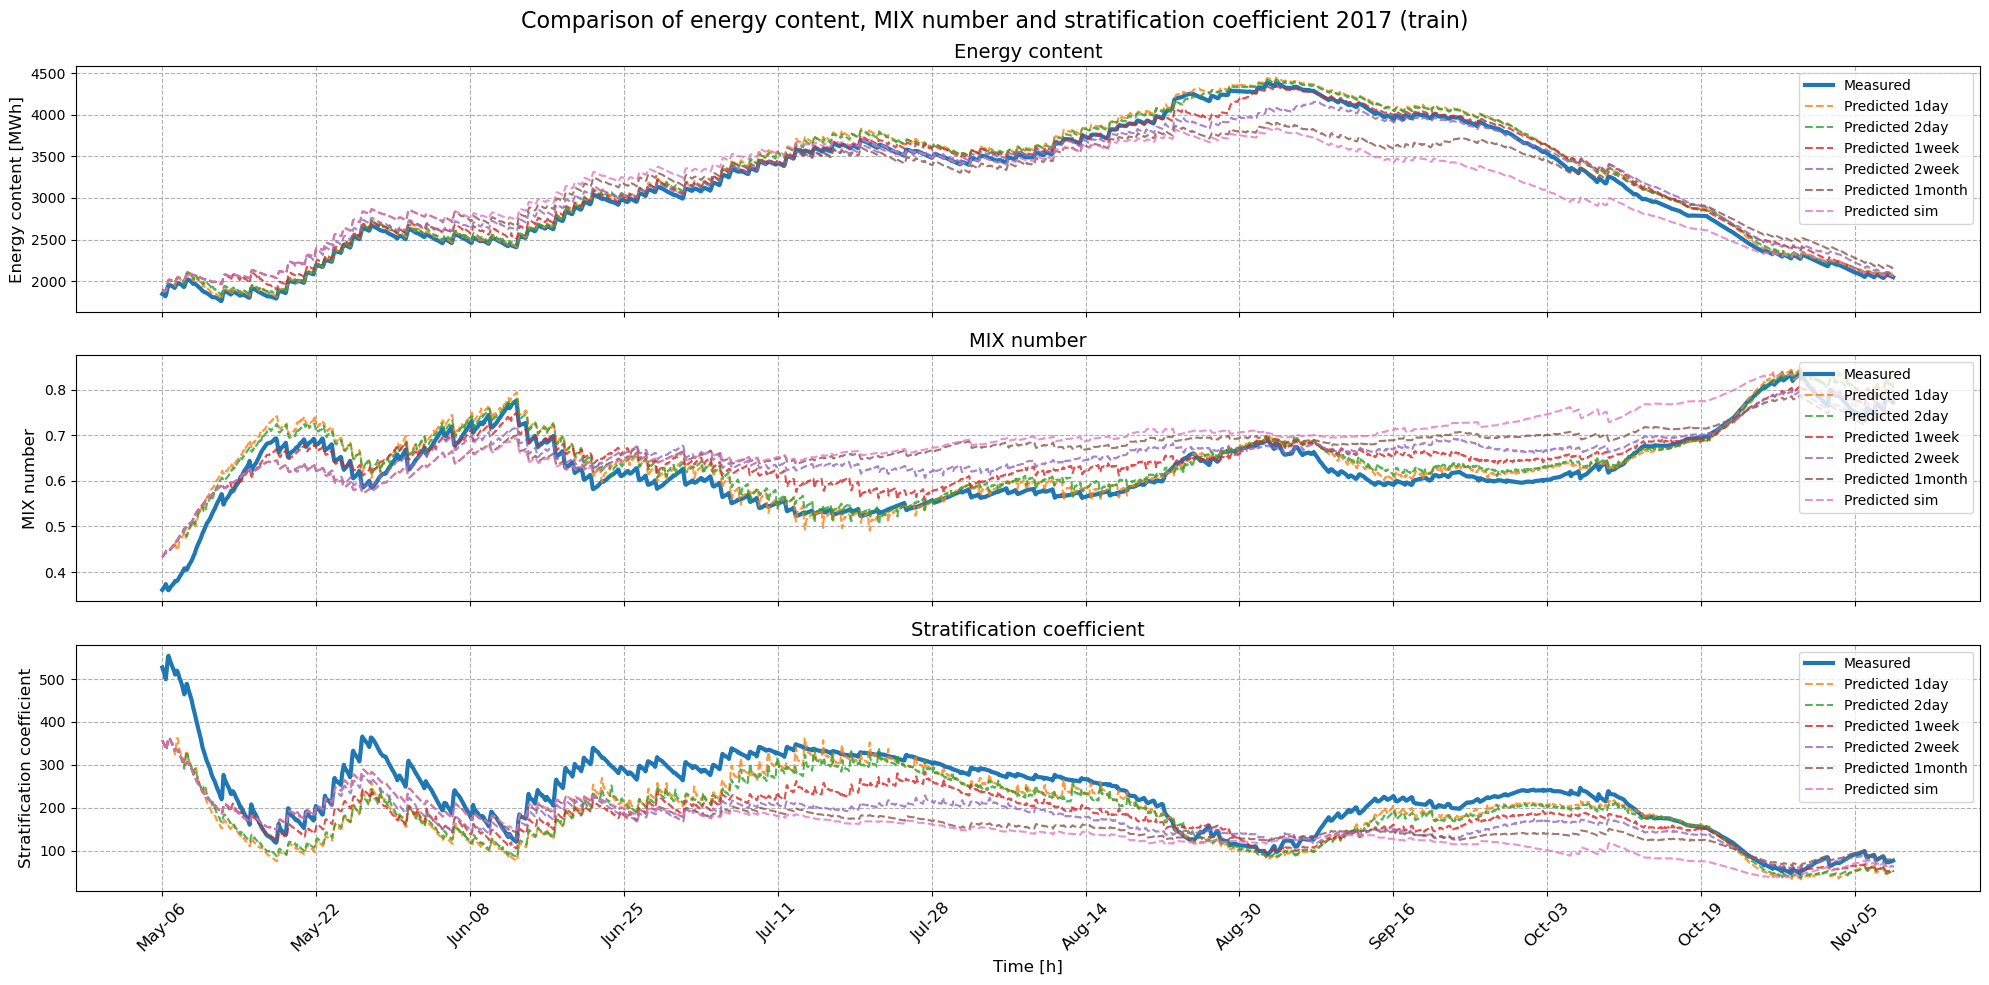

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(20, 10), sharex=True)
labels = ['1day', '2day', '1week', '2week', '1month', 'sim']
MIX_train = (Me_str_true_train - Me_true_train)/(Me_str_true_train - Me_Mix_true_train)

ax[0].plot((E_true_train)/3600000000, label='Measured', linewidth=3)
ax[1].plot(MIX_train, label='Measured', linewidth=3)
ax[2].plot(Str_true_train, label='Measured', linewidth=3)

for i in range(len(train_Me)):
    ax[0].plot((train_E[i]/3600000000), label=f'Predicted {labels[i]}', linestyle='--', alpha = 0.8)
    MIX = (train_Me_str[i] - train_Me[i])/(train_Me_str[i] - train_Me_Mix[i])
    ax[1].plot(MIX, label=f'Predicted {labels[i]}', linestyle='--', alpha = 0.8)

    ax[2].plot(train_S[i], label=f'Predicted {labels[i]}', linestyle='--', alpha = 0.8)

ax[0].legend(loc = 'upper right', fontsize = 10)
ax[0].set_title('Energy content', fontsize = 14)
ax[0].set_ylabel('Energy content [MWh]', fontsize = 12)
ax[0].grid(linestyle = '--')

# ax[1].set_xlabel('Time [h]')
ax[1].legend(loc = 'upper right', fontsize = 10)
ax[1].set_title('MIX number', fontsize = 14)
ax[1].grid(linestyle = '--')
ax[1].set_ylabel('MIX number', fontsize = 12)

ax[2].set_xlabel('Time [h]', fontsize = 12)
ax[2].legend(loc = 'upper right', fontsize = 10)
ax[2].set_title('Stratification coefficient', fontsize = 14)
ax[2].grid(linestyle = '--')
ax[2].set_ylabel('Stratification coefficient', fontsize = 12)

index = water_sensors_train.index
ticks = np.arange(0, len(index), 400)
tick_labels = [index[t].strftime('%b-%d') for t in ticks]
ax[2].set_xticks(ticks)
ax[2].set_xticklabels(tick_labels, rotation=45, fontsize = 12)
# ax[2].se

# Set overall title
fig.suptitle('Comparison of energy content, MIX number and stratification coefficient 2017 (train)', fontsize = 16)
fig.tight_layout()

Text(0.5, 1.0, 'Predicted temperature profiles for p2d')

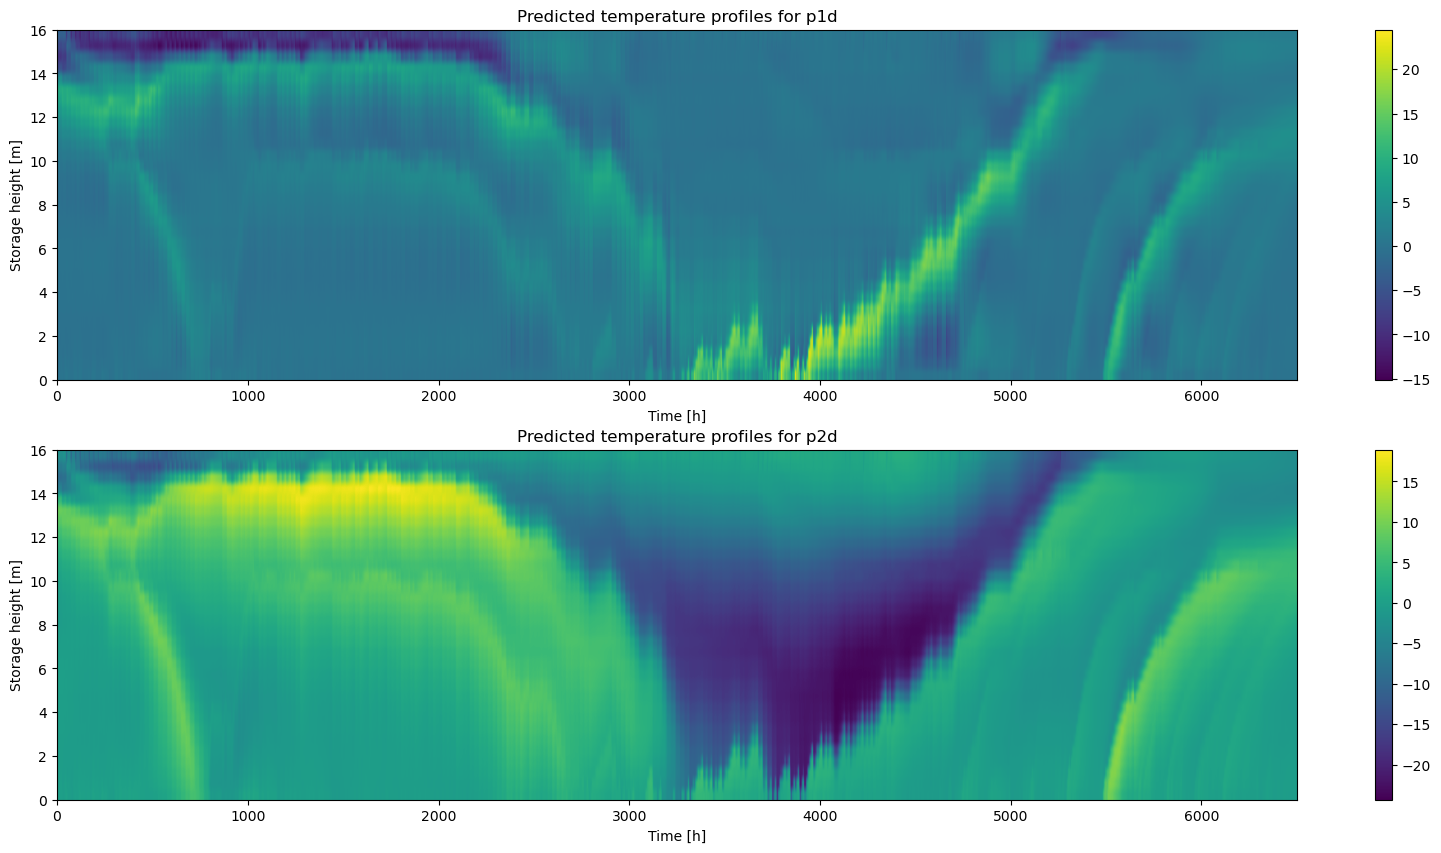

In [ ]:
z = np.arange(0, 16, 0.5)
x1 = np.linspace(0, 16, 6)
def interpolate_pred(pred):
    newdata = pred.apply(lambda x: interp1d(x1, x, kind='cubic')(z), axis=1)
    newdata = newdata.values
    newdata = np.vstack(newdata)
    newdata = pd.DataFrame(newdata, index=pred.index, columns=z)
    return newdata

p1_interp = interpolate_pred(p1d).values
p2_interp = interpolate_pred(sim).values

err1 = (p1_interp[:-1] - water_sensors.values)
err2 = (p2_interp[:-1] - water_sensors.values)

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
im = ax[0].imshow((err1.T), aspect='auto', extent=[0, len(p1_interp), 0, 16], origin='lower')
colorbar = plt.colorbar(im, ax=ax[0])
ax[0].set_xlabel('Time [h]')
ax[0].set_ylabel('Storage height [m]')
ax[0].set_title('Predicted temperature profiles for p1d')


im = ax[1].imshow((err2.T), aspect='auto', extent=[0, len(p2_interp), 0, 16], origin='lower')
colorbar = plt.colorbar(im, ax=ax[1])
ax[1].set_xlabel('Time [h]')
ax[1].set_ylabel('Storage height [m]')
ax[1].set_title('Predicted temperature profiles for p2d')



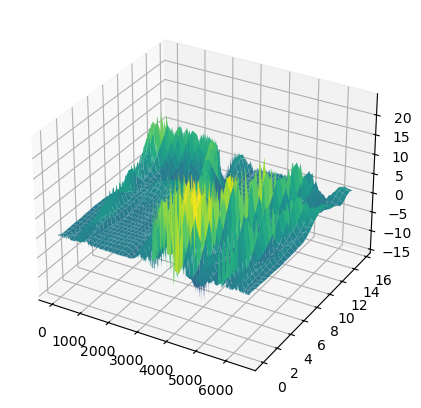

In [ ]:
z = np.arange(0, 16, 0.5)
x1 = np.linspace(0, 16, 6)
def interpolate_pred(pred):
    newdata = pred.apply(lambda x: interp1d(x1, x, kind='cubic')(z), axis=1)
    newdata = newdata.values
    newdata = np.vstack(newdata)
    newdata = pd.DataFrame(newdata, index=pred.index, columns=z)
    return newdata

p1_interp = interpolate_pred(p1d).values[:-1]
p2_interp = interpolate_pred(sim).values

y = water_sensors.values

diff = p1_interp - y

# 3d plot
fig, ax = plt.subplots(1, 1, figsize=(10, 5), subplot_kw={'projection': '3d'})

x = np.arange(0, len(p1_interp))
y = np.arange(0, 16, 0.5)
x, y = np.meshgrid(x, y)
z = p1_interp.T
z = diff.T
ax.plot_surface(x, y, z, cmap='viridis')

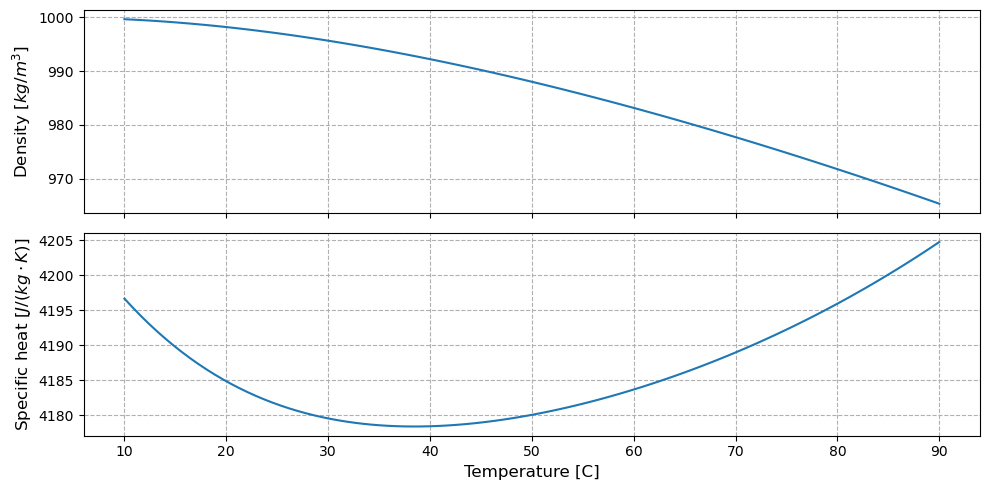

In [ ]:
t = np.linspace(TMIN, TMAX, 100)
rho = density_water(t)
cp = specific_heat_water(t)

fig, ax = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
ax[0].plot(t, rho)
ax[1].plot(t, cp)

ax[1].set_xlabel('Temperature [C]', fontsize = 12)
ax[0].set_ylabel(r'Density $[kg/m^3]$', fontsize = 12)
ax[0].grid(linestyle = '--')
ax[1].set_ylabel(r'Specific heat $[J/(kg\cdot K)]$', fontsize = 12)
ax[1].grid(linestyle = '--')

fig.tight_layout()